In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import os
from scipy.interpolate import interp1d

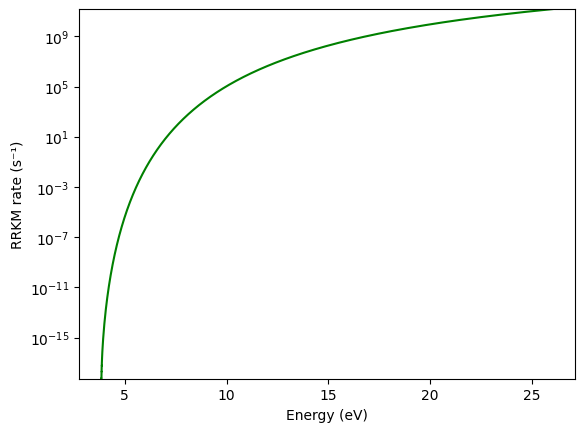

In [16]:
# DENSUM OUTPUT DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\TS-2-cyanopyrene\vibs\densum.out',
    skiprows=138,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
h_wavenumber = 4.135667696e-15 * 8065.56 # Planck's constant in eV/cm^-1
E0_cm = 31052                            # Activation energy in cm^-1 (rounded to cm_grain)
cm_to_eV = 1.239841984e-4                
cm_grain = 10

# LISTS
density_of_states_list = df1["Density"].tolist()
TS_sum_of_states_list = df2["Sum"].tolist()
energies_list = df1["E-Emin"].tolist()
N_k_RRKM_list = []
filtered_energies_list = []

# FUNCTIONS
def RRKM_dissociation_rate(reaction_degen, TS_sum_of_states, density_of_states):
    return (reaction_degen * TS_sum_of_states) / (h_wavenumber * density_of_states)

# CALCULATIONS
for energy, density in zip(energies_list, density_of_states_list):
    if energy <= E0_cm:
        # print("Energy below threshold:", energy)
        continue

    E_available = energy - E0_cm
    # print("E_available:", E_available)
    index = int(E_available / cm_grain)
    # print("Index:", index)

    TS_sum_val = TS_sum_of_states_list[index]
    #print("sum of states:", TS_sum_val, "and density of states:", density)
    k = RRKM_dissociation_rate(reaction_degen=1, TS_sum_of_states=TS_sum_val, density_of_states=density)
    N_k_RRKM_list.append(k)
    filtered_energies_list.append(energy)

# Converts energies from cm^-1 to eV
N_RRKM_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(N_RRKM_filtered_energies_list_eV, N_k_RRKM_list, color='green')
plt.xlabel('Energy (eV)')
plt.ylabel('RRKM rate (s⁻¹)')
plt.yscale('log')
plt.ylim(min(N_k_RRKM_list), max(N_k_RRKM_list))
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ncyp_RRKM.png')

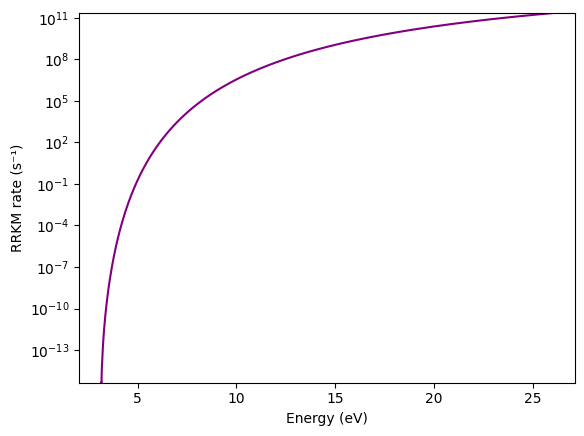

In [17]:
# DENSUM OUTPUT DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\TS-C-2-cyanopyrene\vibs\densum.out',
    skiprows=138,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
h_wavenumber = 4.135667696e-15 * 8065.56
E0_cm = 25490                           
cm_to_eV = 1.239841984e-4                
cm_grain = 10

# LISTS
density_of_states_list = df1["Density"].tolist()
TS_sum_of_states_list = df2["Sum"].tolist()
energies_list = df1["E-Emin"].tolist()
C_k_RRKM_list = []
filtered_energies_list = []

# FUNCTIONS
def RRKM_dissociation_rate(reaction_degen, TS_sum_of_states, density_of_states):
    return (reaction_degen * TS_sum_of_states) / (h_wavenumber * density_of_states)

# CALCULATIONS
for energy, density in zip(energies_list, density_of_states_list):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    TS_sum_val = TS_sum_of_states_list[index]
    k = RRKM_dissociation_rate(reaction_degen=1, TS_sum_of_states=TS_sum_val, density_of_states=density)
    C_k_RRKM_list.append(k)
    filtered_energies_list.append(energy)

C_RRKM_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, color='purple')
plt.xlabel('Energy (eV)')
plt.ylabel('RRKM rate (s⁻¹)')
plt.yscale('log')
plt.ylim(min(C_k_RRKM_list), max(C_k_RRKM_list))
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ccyp_RRKM.png')

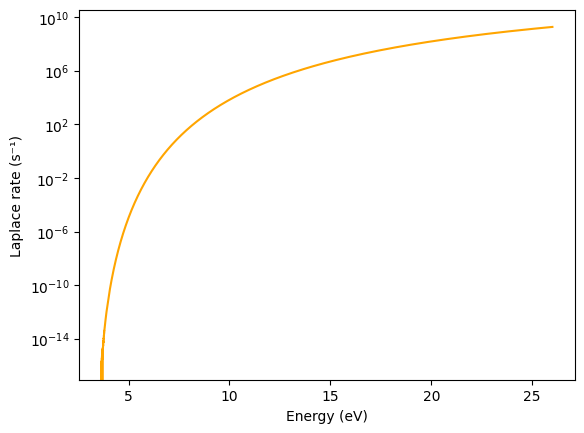

In [18]:
# INVERSE LAPLACE DISSOCIATON RATE

# DOS DATA
df = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
T_eff = 1000
h = 6.62607015e-34 
k_B = 1.380649e-23 
E0_cm = 29520                        
cm_to_eV = 1.239841984e-4
cm_grain = 10

# LISTS
Ncyp_k_Laplace_list = []
filtered_energies_list = []
energies_list = df["E-Emin"]
density_of_states_list1 = df["Density"].tolist()
density_of_states_list2 = df["Density"].tolist()

# FUNCTIONS
def pre_exponential_factor_1000K(T_eff):
    A_diss_1000K = k_B * T_eff / h
    return A_diss_1000K

def Laplace_dissociation_rate(A_diss_1000K, DOS_E_Ea, DOS_E):
    k_diss_laplace = (A_diss_1000K * DOS_E_Ea) / DOS_E
    return k_diss_laplace
    
# CALCULATIONS
for energy, unchanged_DOS in zip(energies_list, density_of_states_list2):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    changed_DOS = density_of_states_list1[index]
    k = Laplace_dissociation_rate(A_diss_1000K=(pre_exponential_factor_1000K(T_eff)), DOS_E_Ea=changed_DOS, DOS_E=unchanged_DOS)
    Ncyp_k_Laplace_list.append(k)
    filtered_energies_list.append(energy)

Ncyp_LP_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(Ncyp_LP_filtered_energies_list_eV, Ncyp_k_Laplace_list, color='orange')
plt.xlabel('Energy (eV)')
plt.ylabel('Laplace rate (s⁻¹)')
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ncyp_LP.png')

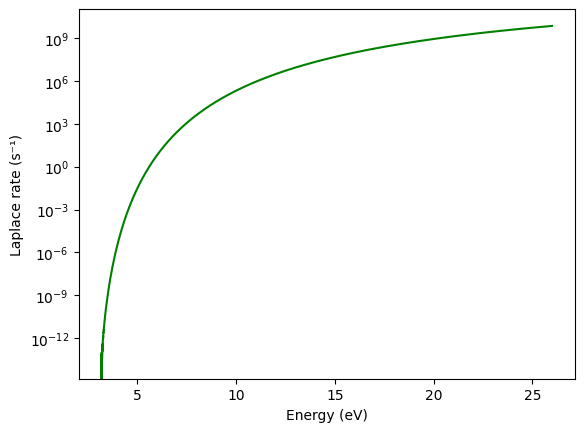

In [19]:
# INVERSE LAPLACE DISSOCIATON RATE

# DOS DATA
df = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
T_eff = 1000
h = 6.62607015e-34 
k_B = 1.380649e-23 
E0_cm = 25490                           
cm_to_eV = 1.239841984e-4
cm_grain = 10

# LISTS
Ccyp_k_Laplace_list = []
filtered_energies_list = []
energies_list = df["E-Emin"]
density_of_states_list1 = df["Density"].tolist()
density_of_states_list2 = df["Density"].tolist()

# FUNCTIONS
def pre_exponential_factor_1000K(T_eff):
    A_diss_1000K = k_B * T_eff / h
    return A_diss_1000K

def Laplace_dissociation_rate(A_diss_1000K, DOS_E_Ea, DOS_E):
    k_diss_laplace = (A_diss_1000K * DOS_E_Ea) / DOS_E
    return k_diss_laplace
    
# CALCULATIONS
for energy, unchanged_DOS in zip(energies_list, density_of_states_list2):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    changed_DOS = density_of_states_list1[index]
    k = Laplace_dissociation_rate(A_diss_1000K=(pre_exponential_factor_1000K(T_eff)), DOS_E_Ea=changed_DOS, DOS_E=unchanged_DOS)
    Ccyp_k_Laplace_list.append(k)
    filtered_energies_list.append(energy)

Ccyp_LP_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(Ccyp_LP_filtered_energies_list_eV, Ccyp_k_Laplace_list, color='green')
plt.xlabel('Energy (eV)')
plt.ylabel('Laplace rate (s⁻¹)')
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ccyp_LP.png')

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_15516\137240724.py:60: RuntimeWarning: invalid value encountered in scalar divide
  k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]


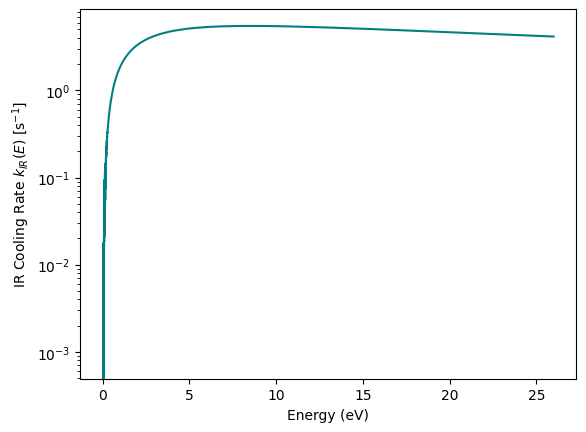

<Figure size 640x480 with 0 Axes>

In [20]:
# THE INFRARED RADIATIVE VIBRATIONAL COOLING RATE 

# WAVENUMBER-INTENSITY & DENSUM DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\IRdata\scaled_frequencies\CNpy_scaled_output.txt',
    skiprows=1,
    sep='\s+',
    names=["Wavenumber", "Intensity"])

mode_i_path = r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\2-cyanopyrene\vibs\densum_mode_sweeps\mode_{i}\densum.out'
density_mode = {}

for i in range(1, 76):  # Vib modes 1 to 75
    path = mode_i_path.format(i=i)
    if os.path.exists(path):
        df_i = pd.read_csv(path, skiprows=138, sep='\s+', names=["No.", "E-Emin", "Density", "Sum"])
        density_mode[i] = df_i["Density"].values

# LISTS
A_IR_list = []
energy_s_list = []
DOS_list = []
filtered_energies_list = []
wavenumber_list = df2["Wavenumber"].tolist()
intensity_list = df2["Intensity"].tolist()
energies_list = df1["E-Emin"].tolist()
density_of_states_list = df1["Density"].tolist()
N_k_IR_total = np.zeros_like(density_of_states_list) 
DOS_mode_s_dict = {}  # Dictionary to store DOS_mode_s values for each mode

# FUNCTIONS
def einstein_coefficient(wavenumber, intensity):
    A = (1.2512 * 10**(-7)) * (wavenumber ** 2) * intensity
    return A

# CALCULATIONS
for wavenumber, intensity in zip(wavenumber_list, intensity_list):
    A_IR = einstein_coefficient(wavenumber, intensity)
    A_IR_list.append(A_IR)

for mode in range(1, 52):
    wavenumber_s = wavenumber_list[mode - 1]
    rounded_wavenumber = round(wavenumber_s / 10) * 10
    A_IR = A_IR_list[mode - 1]
    # rho_minus_i = density_mode[mode]

    for idx, e in enumerate(energies_list):
        if e <= rounded_wavenumber:
            continue
        E_available = e - rounded_wavenumber
        index = int(E_available / cm_grain)

        DOS_mode_s = density_mode[mode][index]
        k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]
        N_k_IR_total[idx] += k_IR

N_IR_energies_list_eV = [e * cm_to_eV for e in energies_list]

# OPTIONAL PLOTTING
plt.plot(N_IR_energies_list_eV, N_k_IR_total, color='teal')
plt.xlabel("Energy (eV)")
plt.ylabel("IR Cooling Rate $k_{IR}(E)$ [s$^{-1}$]")
plt.yscale('log')
plt.show()
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ncyp_IR.png')

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_15516\460017072.py:60: RuntimeWarning: invalid value encountered in scalar divide
  k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]


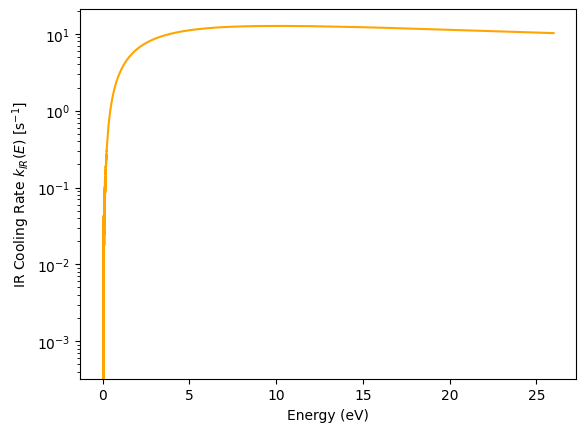

<Figure size 640x480 with 0 Axes>

In [21]:
# THE INFRARED RADIATIVE VIBRATIONAL COOLING RATE 

# WAVENUMBER-INTENSITY & DENSUM DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\IRdata\scaled_frequencies\CNpy+_scaled_output.txt',
    skiprows=1,
    sep='\s+',
    names=["Wavenumber", "Intensity"])

mode_i_path = r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum_mode_sweeps\mode_{i}\densum.out'
density_mode = {}

for i in range(1, 76):  # Vib modes 1 to 75
    path = mode_i_path.format(i=i)
    if os.path.exists(path):
        df_i = pd.read_csv(path, skiprows=138, sep='\s+', names=["No.", "E-Emin", "Density", "Sum"])
        density_mode[i] = df_i["Density"].values

# LISTS
A_IR_list = []
energy_s_list = []
DOS_list = []
filtered_energies_list = []
wavenumber_list = df2["Wavenumber"].tolist()
intensity_list = df2["Intensity"].tolist()
energies_list = df1["E-Emin"].tolist()
density_of_states_list = df1["Density"].tolist()
C_k_IR_total = np.zeros_like(density_of_states_list) 
DOS_mode_s_dict = {}  # Dictionary to store DOS_mode_s values for each mode

# FUNCTIONS
def einstein_coefficient(wavenumber, intensity):
    A = (1.2512 * 10**(-7)) * (wavenumber ** 2) * intensity
    return A

# CALCULATIONS
for wavenumber, intensity in zip(wavenumber_list, intensity_list):
    A_IR = einstein_coefficient(wavenumber, intensity)
    A_IR_list.append(A_IR)

for mode in range(1, 52):
    wavenumber_s = wavenumber_list[mode - 1]
    rounded_wavenumber = round(wavenumber_s / 10) * 10
    A_IR = A_IR_list[mode - 1]
    # rho_minus_i = density_mode[mode]

    for idx, e in enumerate(energies_list):
        if e <= rounded_wavenumber:
            continue
        E_available = e - rounded_wavenumber
        index = int(E_available / cm_grain)

        DOS_mode_s = density_mode[mode][index]
        k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]
        C_k_IR_total[idx] += k_IR

C_IR_energies_list_eV = [e * cm_to_eV for e in energies_list]

# OPTIONAL PLOTTING
plt.plot(C_IR_energies_list_eV, C_k_IR_total, color='orange')
plt.xlabel("Energy (eV)")
plt.ylabel("IR Cooling Rate $k_{IR}(E)$ [s$^{-1}$]")
plt.yscale('log')
plt.show()
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ccyp_IR.png')

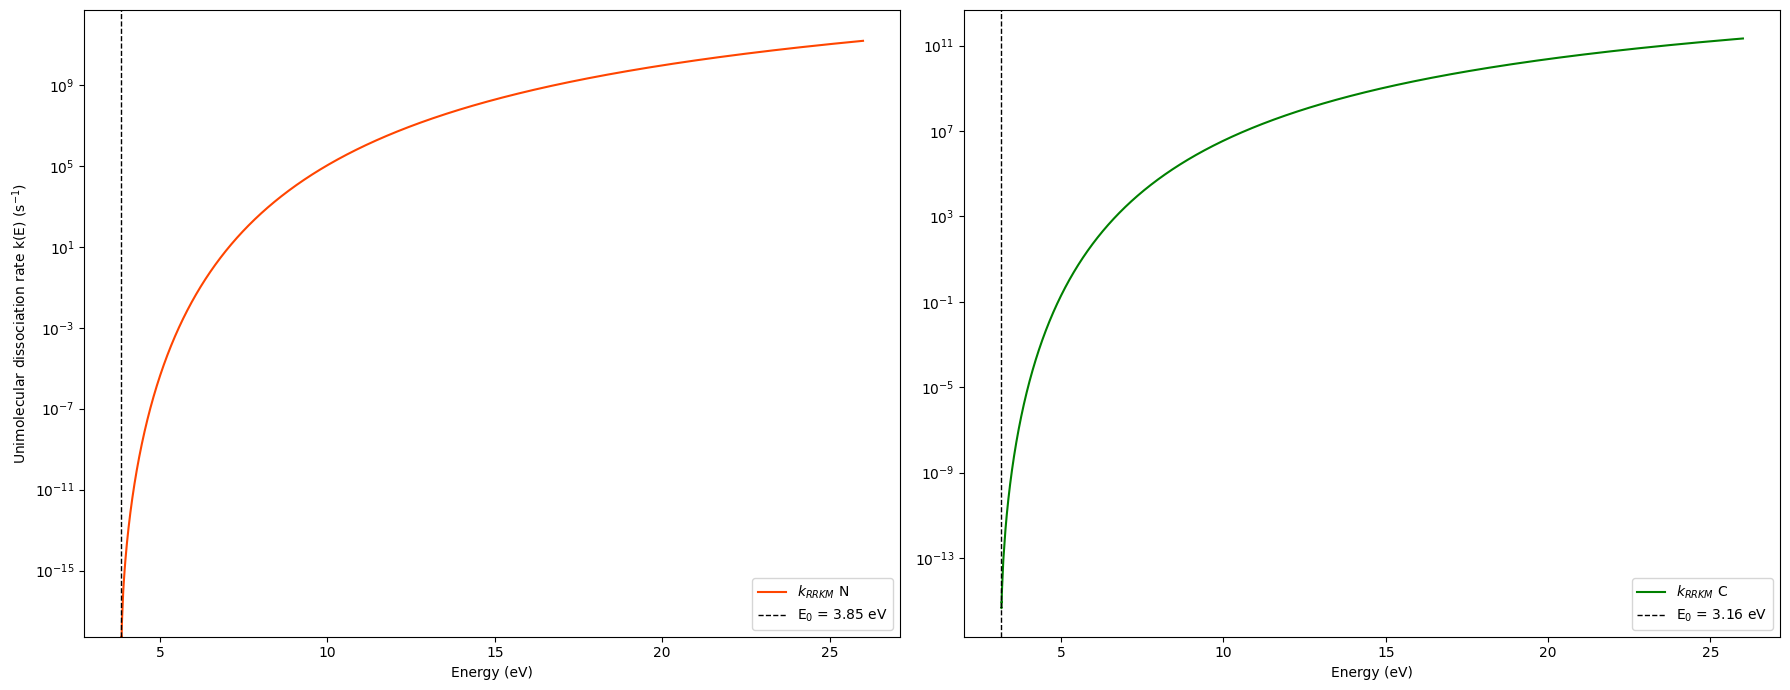

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# NEUTRAL 1-CYANONAPHTHALENE DISSOCIATION RATES
axs[0].plot(N_RRKM_filtered_energies_list_eV, N_k_RRKM_list, label='$k_{RRKM}$ N', color='orangered')
axs[0].axvline(x=3.85, color='black', linestyle='--', linewidth=1, label='E$_0$ = 3.85 eV')
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Unimolecular dissociation rate k(E) (s$^{-1}$)')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_ylim(N_k_RRKM_list[0], 5e12)

# CATION 1-CYANONAPHTHALENE DISSOCIATION RATES
axs[1].plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, label='$k_{RRKM}$ C', color='green')
axs[1].axvline(x=3.16, color='black', linestyle='--', linewidth=1, label='E$_0$ = 3.16 eV')
axs[1].set_xlabel('Energy (eV)')
axs[1].set_yscale('log')
axs[1].legend()
plt.tight_layout()

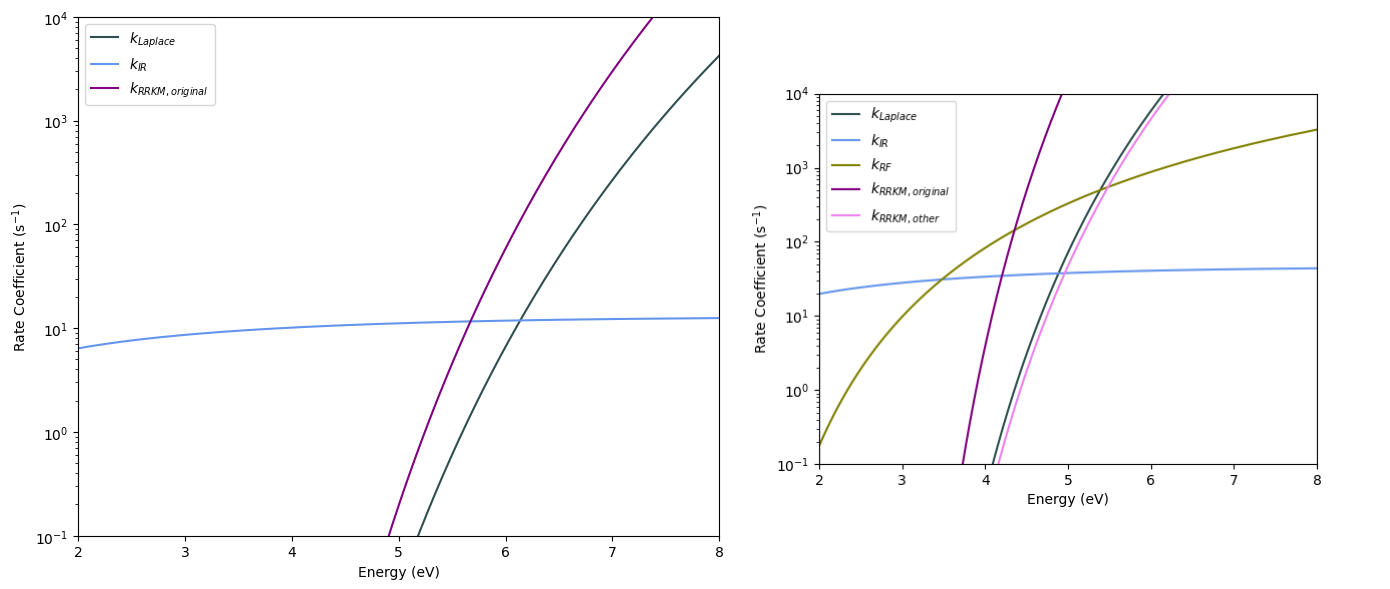

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(Ccyp_LP_filtered_energies_list_eV, Ccyp_k_Laplace_list, color='darkslategrey', label='$k_{Laplace}$')
axs[0].plot(C_IR_energies_list_eV, C_k_IR_total, color='cornflowerblue', label='$k_{IR}$')
axs[0].plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, color='purple', label='$k_{RRKM, original}$')
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Rate Coefficient (s$^{-1}$)')
axs[0].set_yscale('log')
axs[0].legend(loc='upper left')
axs[0].set_xlim(2, 8)
axs[0].set_ylim(1e-1, 1e4)

img = mpimg.imread('Cation-1cyano-rates.png')
axs[1].imshow(img)
axs[1].axis('off')
plt.tight_layout()